In [127]:
#Imports
#exploration, cleaning
import pandas as pd, numpy as np, matplotlib.pyplot as plt 
from datetime import datetime

#predictions
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [90]:
# I renamed the csv files to make them easier to work with
features = pd.read_csv('data/features.csv')
stores = pd.read_csv('data/stores.csv')
sales = pd.read_csv('data/sales.csv')


## Cleaning the features data set

In [91]:
 # I made this function to quickly describe the data since we are working with 3 data sets
def quickDescribe(df):
    print('\n', '##Example##\n' , df.sample(n=5))
    print('\n', '##Shape', df.shape )
    print('\n', '##stats##\n', df.describe())
    print('\n', '##datatypes##\n', df.info()) # for some reason the ##datatype## is below the the df.info output?
    print('\n', '##nulls##\n' , df.isnull().sum())
quickDescribe(features)


 ##Example##
       Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
7495     42  24/09/2010        85.75       2.939        NaN        NaN   
4862     27  03/08/2012        75.22       3.819   39317.03     194.67   
2321     13  21/09/2012        67.96       3.821   10671.71     141.83   
2282     13  23/12/2011        24.76       3.186     686.24     193.26   
5062     28  07/12/2012        57.83       3.668    9232.97        NaN   

      MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
7495        NaN        NaN        NaN  126.190033         9.199      False  
4862      64.32   25462.22    3161.43  142.191628         8.239      False  
2321      46.00    2465.37   12372.29  131.010333         5.765      False  
2282    2971.53     239.78    3567.03  129.984548         6.392      False  
5062     413.24    2404.59   12278.82  131.478400        10.199      False  

 ##Shape (8190, 12)

 ##stats##
              Store  Temperature   Fuel_Price

In [125]:
# DateTime Conversion
features['Date'] = pd.to_datetime(features['Date'], dayfirst=True) 
features['Date'].dtype == 'datetime64[ns]'

True

In [93]:
missing_CPI_Dates = features['Date'].loc[features['CPI'].isnull()]
missing_CPI_Dates.groupby(missing_CPI_Dates.dt.year).count() # I grouped the missing CPI dates by year to see if there was a pattern

Date
2013    585
Name: Date, dtype: int64

In [94]:
# Ive commented out these two approaches, to see which approach gives the best predicitvie accuracy
# Seeing as the miscosg values are all from 2013, I will fill them with the mean of the column
# features['CPI'] = features['CPI'].fillna(features['CPI'].mean())
# # I will do the same for the unemployment column
# features['Unemployment'] = features['Unemployment'].fillna(features['Unemployment'].mean())
# Since they are both from 2013, we may end up dropping the whole year from the data set
# features = features.dropna() # I decided to drop the whole year since it is only 3 rows of data]
# sales = sales.dropna() # I decided to drop the whole year since it is only 3 rows of data



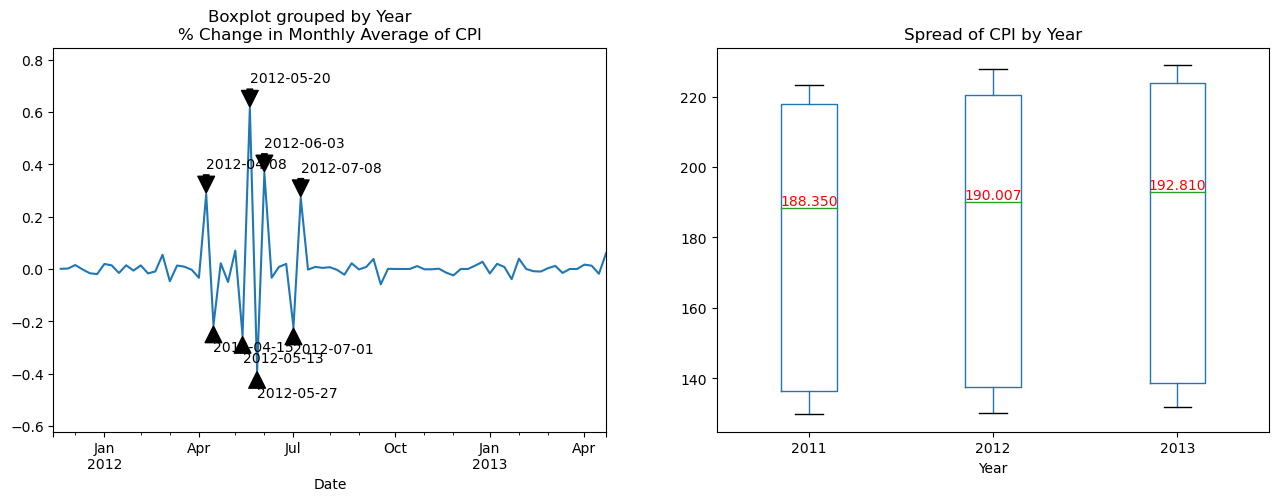

In [95]:
fig, axs = plt.subplots(1,2)

droppedFeatures = features.dropna()
cpi = droppedFeatures['CPI']
cpi_dates = droppedFeatures['Date']

graphDF = pd.DataFrame({'CPI': cpi, 'Date': cpi_dates})
graphDF = graphDF.set_index('Date')

groupedChange = graphDF.groupby(pd.Grouper(freq="W")).mean().pct_change()
groupedChange

grouped_data = graphDF.groupby(graphDF.index.year)



fig1 = groupedChange.plot(kind='line',
                           ylim=(groupedChange['CPI'].min() - groupedChange['CPI'].std()*2, groupedChange['CPI'].max() + groupedChange['CPI'].std()*2),
                             ax=axs[0], title='% Change in Monthly Average of CPI', legend=False)

#set an annotation of the date if the change is greater than 0.1
for i in range(len(groupedChange)):
    if groupedChange.iloc[i]['CPI'] > 0.1:
        fig1.annotate(groupedChange.index[i].strftime('%Y-%m-%d'), xy=(groupedChange.index[i], groupedChange.iloc[i]['CPI']), xytext=(groupedChange.index[i], groupedChange.iloc[i]['CPI'] + 0.1),
                     arrowprops=dict(facecolor='black', shrink=0.05),)
    if groupedChange.iloc[i]['CPI'] < -0.1:
        fig1.annotate(groupedChange.index[i].strftime('%Y-%m-%d'), xy=(groupedChange.index[i], groupedChange.iloc[i]['CPI']), xytext=(groupedChange.index[i], groupedChange.iloc[i]['CPI'] - 0.1),
                     arrowprops=dict(facecolor='black', shrink=0.05),)
        
    

df = pd.DataFrame({'CPI': cpi, 'Date': cpi_dates})
df['Date'] = pd.to_datetime(df['Date']).dt.year
df.rename(columns={'Date': 'Year'}, inplace=True)
fig2 = df.boxplot(by='Year', column='CPI', figsize=(12,8), ax=axs[1], grid=False)
fig2.set_title('Spread of CPI by Year')

## setting label
i = 0
for year in df['Year'].unique():
  median_value = df['CPI'].loc[df['Year'] == year].median()
  text_x = fig2.get_xticks()[i]
  text_y = median_value
  i += 1
  axs[1].text(text_x, text_y, f'{median_value:.3f}', color='r', ha='center', va='bottom')

plt.subplots_adjust(bottom=0.1, right=2,)
plt.show()

# Thanks to:
# https://stackoverflow.com/a/16393023 
# https://stackoverflow.com/a/45229527

## Samples Dataset

In [96]:
sales.sample(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday
346768,37,2,27/04/2012,16792.61,False
252225,26,41,18/03/2011,1183.00,False
51795,6,23,24/09/2010,22238.53,False
16807,2,54,25/03/2011,33.92,False
398091,43,1,05/08/2011,4035.44,False


<h3> Examining The top, bottom stores

In [97]:
#merging sales, stores
sales_with_stores = pd.merge(stores, sales, on='Store', how='outer')
quickDescribe(sales_with_stores)


 ##Example##
         Store Type    Size  Dept        Date  Weekly_Sales  IsHoliday
103919     11    A  207499    49  04/02/2011       6784.13      False
215045     22    B  119557    81  24/06/2011      11333.08      False
307529     32    A  203007    27  24/08/2012       1273.84      False
166039     17    B   93188    85  04/05/2012       3051.71      False
42008       5    B   34875    17  01/07/2011       1864.95      False

 ##Shape (421570, 7)

 ##stats##
                Store           Size           Dept   Weekly_Sales
count  421570.000000  421570.000000  421570.000000  421570.000000
mean       22.200546  136727.915739      44.260317   15981.258123
std        12.785297   60980.583328      30.492054   22711.183519
min         1.000000   34875.000000       1.000000   -4988.940000
25%        11.000000   93638.000000      18.000000    2079.650000
50%        22.000000  140167.000000      37.000000    7612.030000
75%        33.000000  202505.000000      74.000000   20205.852500
ma

In [98]:
#extracting year 
sales_with_stores['year'] = sales['Date'].apply(lambda x: x[-4:])
sales_with_stores.head()

,Store,Type,Size,Dept,Date,Weekly_Sales,IsHoliday,year
0,1,A,151315,1,05/02/2010,24924.50,False,2010
1,1,A,151315,1,12/02/2010,46039.49,True,2010
2,1,A,151315,1,19/02/2010,41595.55,False,2010
3,1,A,151315,1,26/02/2010,19403.54,False,2010
4,1,A,151315,1,05/03/2010,21827.90,False,2010


In [99]:
# #determining % change between years
# stores_by_year = sales_with_stores.groupby(['year', 'Store'])['Weekly_Sales'].sum().reset_index()

# stores_by_year['pct_change'] = stores_by_year.groupby('Store')['Weekly_Sales'].pct_change().fillna(0)

# stores_by_year.tail(10)


,year,Store,Weekly_Sales,pct_change
125,2012,36,13286470.53,-0.299703
126,2012,37,22612774.69,-0.165010
127,2012,38,18631073.45,-0.065679
128,2012,39,65885662.85,-0.130539
129,2012,40,41172407.34,-0.182122
130,2012,41,56887839.93,-0.147312
131,2012,42,24950359.85,-0.143109
132,2012,43,26975233.97,-0.158423
133,2012,44,14187373.72,-0.084579
134,2012,45,32723630.17,-0.204489


In [100]:
stores_by_year = sales_with_stores.groupby(['year', 'Store'])['Weekly_Sales'].sum().reset_index()
stores_by_year = stores_by_year.merge(stores[["Store", 'Type']], how='left', on='Store')

stores_by_year['pct_change'] = stores_by_year.groupby('Store')['Weekly_Sales'].pct_change().fillna(0)
stores_by_year.merge(stores[["Store" ,'Type']], how='left', on='Store')

stores_by_year.tail(10)
stores_by_year.loc[stores_by_year['pct_change']  > 0, 'graph_color'] = "green"
stores_by_year.loc[stores_by_year['pct_change']  == 0, 'graph_color'] = "blue"
stores_by_year.loc[stores_by_year['pct_change']  < 0, 'graph_color'] = "red"
quickDescribe(stores_by_year)


 ##Example##
     year  Store  Weekly_Sales Type  pct_change graph_color
55  2011     11   70523582.89    A    0.080736       green
88  2011     44   15498194.67    C    0.138943       green
53  2011      9   28685969.65    B    0.141538       green
90  2012      1   68202058.02    A   -0.157187         red
70  2011     26   52049251.72    A    0.075604       green

 ##Shape (135, 6)

 ##stats##
             Store  Weekly_Sales  pct_change
count  135.000000  1.350000e+02  135.000000
mean    23.000000  4.990533e+07   -0.034659
std     13.035543  2.636476e+07    0.115167
min      1.000000  1.143555e+07   -0.299703
25%     12.000000  2.696103e+07   -0.157805
50%     23.000000  4.635736e+07    0.000000
75%     34.000000  6.795558e+07    0.035948
max     45.000000  1.110923e+08    0.202134
<class 'pandas.core.frame.DataFrame'>
Int64Index: 135 entries, 0 to 134
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year    

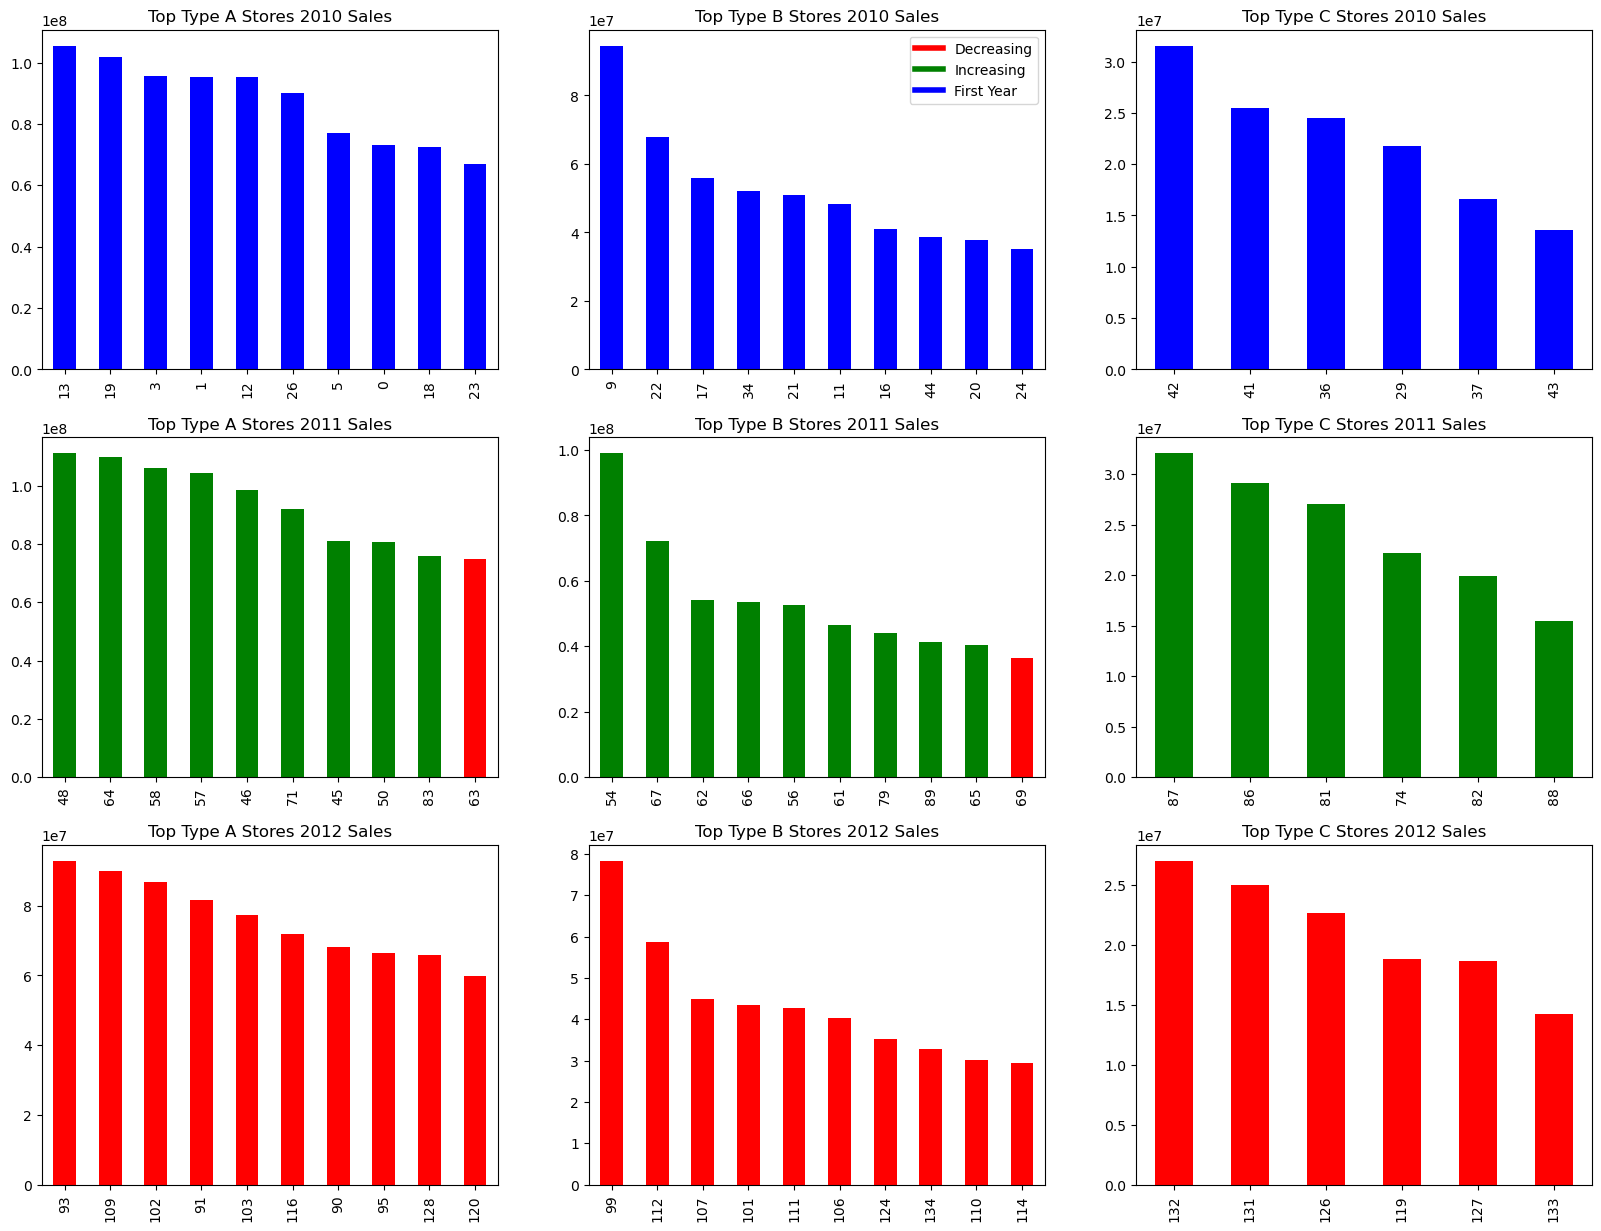

In [101]:
fig, axs = plt.subplots(3,3)
fig.set_size_inches(20, 15)
i=2
for i, year in enumerate(stores_by_year['year'].unique()):
    # print(i, year)
    fig1 = stores_by_year.loc[(stores_by_year['Type'] == 'A') & (stores_by_year['year'] == year) ].sort_values(by='Weekly_Sales', ascending=False).head(10).plot(
        kind = 'bar', y='Weekly_Sales', ax=axs[i,0], color=stores_by_year.loc[(stores_by_year['Type'] == 'B') & (stores_by_year['year'] == year)]['graph_color'],
          title=f"Top Type A Stores {year} Sales", legend=None)
    fig2 = stores_by_year.loc[(stores_by_year['Type'] == 'B') & (stores_by_year['year'] == year)].sort_values(by='Weekly_Sales', ascending=False).head(10).plot(
        kind = 'bar', y='Weekly_Sales', ax=axs[i,1], color=stores_by_year.loc[(stores_by_year['Type'] == 'B') & (stores_by_year['year'] == year)]['graph_color'],
          title=f"Top Type B Stores {year} Sales", legend=None)
    fig3 = stores_by_year.loc[(stores_by_year['Type'] == 'C') & (stores_by_year['year'] == year) ].sort_values(by='Weekly_Sales', ascending=False).head(10).plot(
        kind = 'bar', y='Weekly_Sales', ax=axs[i,2], color=stores_by_year.loc[(stores_by_year['Type'] == 'B') & (stores_by_year['year'] == year)]['graph_color'],
          title=f"Top Type C Stores {year} Sales", legend=False)
    from matplotlib.lines import Line2D
    legend_elements = [

    Line2D([0], [0], color='red', lw=4, label='Decreasing'),
    Line2D([0], [0], color='green', lw=4, label='Increasing'),
    Line2D([0], [0], color='Blue', lw=4, label='First Year')
    ]
    axs[0,1].legend(handles=legend_elements, loc='best')


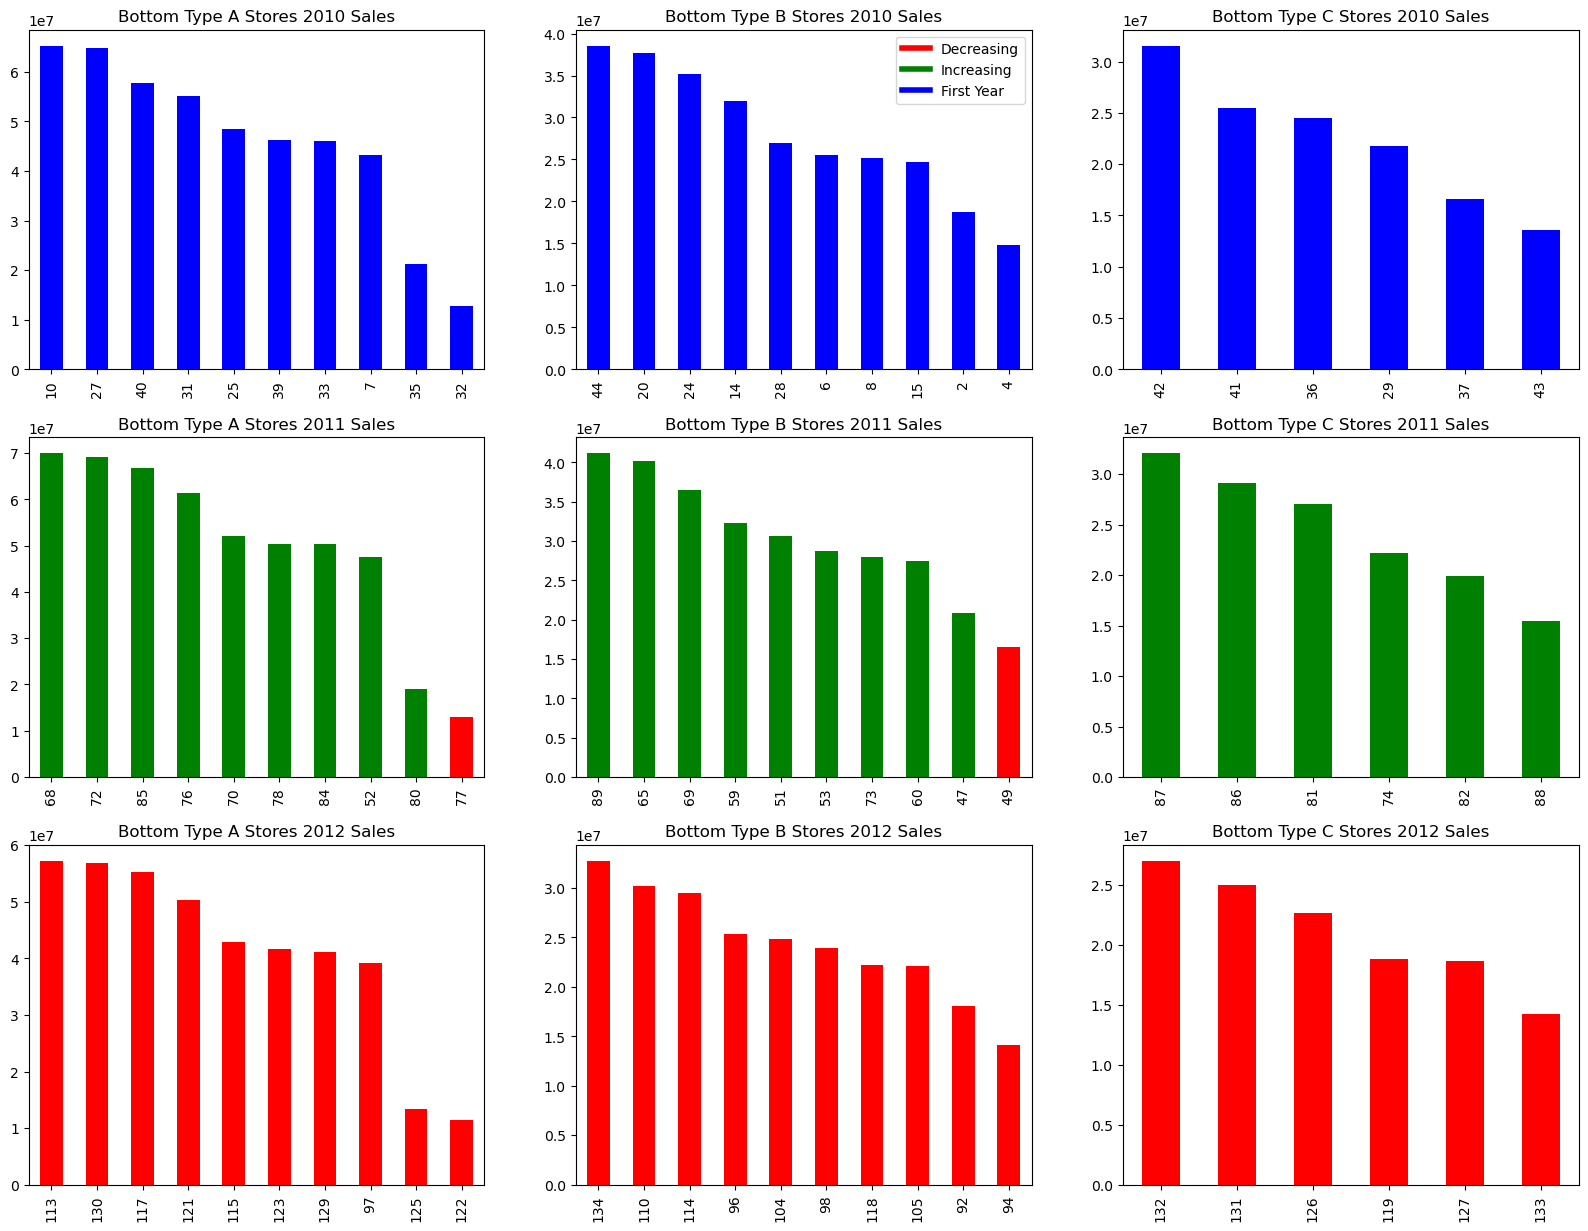

In [102]:
fig, axs = plt.subplots(3,3)
fig.set_size_inches(20, 15)
i=2
for i, year in enumerate(stores_by_year['year'].unique()):
    # print(i, year)
    fig1 = stores_by_year.loc[(stores_by_year['Type'] == 'A') & (stores_by_year['year'] == year) ].sort_values(by='Weekly_Sales', ascending=False).tail(10).plot(
        kind = 'bar', y='Weekly_Sales', ax=axs[i,0], color=stores_by_year.loc[(stores_by_year['Type'] == 'B') & (stores_by_year['year'] == year)]['graph_color'],
          title=f"Bottom Type A Stores {year} Sales", legend=None)
    fig2 = stores_by_year.loc[(stores_by_year['Type'] == 'B') & (stores_by_year['year'] == year)].sort_values(by='Weekly_Sales', ascending=False).tail(10).plot(
        kind = 'bar', y='Weekly_Sales', ax=axs[i,1], color=stores_by_year.loc[(stores_by_year['Type'] == 'B') & (stores_by_year['year'] == year)]['graph_color'],
          title=f"Bottom Type B Stores {year} Sales", legend=None)
    fig3 = stores_by_year.loc[(stores_by_year['Type'] == 'C') & (stores_by_year['year'] == year) ].sort_values(by='Weekly_Sales', ascending=False).tail(10).plot(
        kind = 'bar', y='Weekly_Sales', ax=axs[i,2], color=stores_by_year.loc[(stores_by_year['Type'] == 'B') & (stores_by_year['year'] == year)]['graph_color'],
          title=f"Bottom Type C Stores {year} Sales", legend=False)
    from matplotlib.lines import Line2D
    legend_elements = [

    Line2D([0], [0], color='red', lw=4, label='Decreasing'),
    Line2D([0], [0], color='green', lw=4, label='Increasing'),
    Line2D([0], [0], color='Blue', lw=4, label='First Year')
    ]
    axs[0,1].legend(handles=legend_elements, loc='best')


In [103]:
sales['Date'] = [datetime.strptime(date, '%d/%m/%Y') for date in sales['Date']] # I converted the date column to datetime format
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


In [104]:
salesViZ = sales
salesViZ['Date'] = pd.to_datetime(salesViZ['Date'])


In [105]:
def is_pre_holiday(date):
    for key, value in timeDict.items():
        # Check if the date falls within the same week as the holiday
        if date > value and date < key:
            return True
    return False


In [106]:
holidays = salesViZ[salesViZ['IsHoliday'] == True]
holiday_dates = holidays['Date'].unique()
high_priority_dates = []
for date in holiday_dates:
    four_weeks_before_holiday = date - pd.DateOffset(weeks=4)
    high_priority_dates.append(np.datetime64(four_weeks_before_holiday))
    
zipped = zip(holiday_dates, high_priority_dates)
timeDict = dict(zipped)

salesViZ['pre_holiday'] = salesViZ['Date'].apply(is_pre_holiday)
salesViZ.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,pre_holiday
0,1,1,2010-02-05,24924.50,False,True
1,1,1,2010-02-12,46039.49,True,False
2,1,1,2010-02-19,41595.55,False,False
3,1,1,2010-02-26,19403.54,False,False
4,1,1,2010-03-05,21827.90,False,False


In [107]:
salesViZ['Holiday_Status'] = ''

# Set the holiday status based on the encoded values
salesViZ.loc[(salesViZ['IsHoliday'] == True) & (salesViZ['pre_holiday'] == True), 'Holiday_Status'] = 'Holiday'
salesViZ.loc[(salesViZ['IsHoliday'] == True) & (salesViZ['pre_holiday'] == False), 'Holiday_Status'] = 'Holiday'
salesViZ.loc[(salesViZ['IsHoliday'] == False) & (salesViZ['pre_holiday'] == True), 'Holiday_Status'] = 'Pre-Holiday'
salesViZ.loc[(salesViZ['IsHoliday'] == False) & (salesViZ['pre_holiday'] == False), 'Holiday_Status'] = 'Non-Holiday'

# salesViZ.drop('pre_holiday', axis=1, inplace=True)
# salesViZ.drop('IsHoliday', axis=1, inplace=True)
salesViZ.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status
0,1,1,2010-02-05,24924.50,False,True,Pre-Holiday
1,1,1,2010-02-12,46039.49,True,False,Holiday
2,1,1,2010-02-19,41595.55,False,False,Non-Holiday
3,1,1,2010-02-26,19403.54,False,False,Non-Holiday
4,1,1,2010-03-05,21827.90,False,False,Non-Holiday


In [108]:
weeklysales = salesViZ.groupby(['Date', 'Holiday_Status']).sum()['Weekly_Sales'].reset_index()
weeklysales.head()

,Date,Holiday_Status,Weekly_Sales
0,2010-02-05,Pre-Holiday,49750740.50
1,2010-02-12,Holiday,48336677.63
2,2010-02-19,Non-Holiday,48276993.78
3,2010-02-26,Non-Holiday,43968571.13
4,2010-03-05,Non-Holiday,46871470.30


In [109]:
weeklysales.head()
pivotsales = weeklysales.pivot(index='Date', columns='Holiday_Status', values='Weekly_Sales')
pivotsales.head()

Holiday_Status,Holiday,Non-Holiday,Pre-Holiday
Date,,,
2010-02-05,NaN,NaN,49750740.5
2010-02-12,48336677.63,NaN,NaN
2010-02-19,NaN,48276993.78,NaN
2010-02-26,NaN,43968571.13,NaN
2010-03-05,NaN,46871470.30,NaN


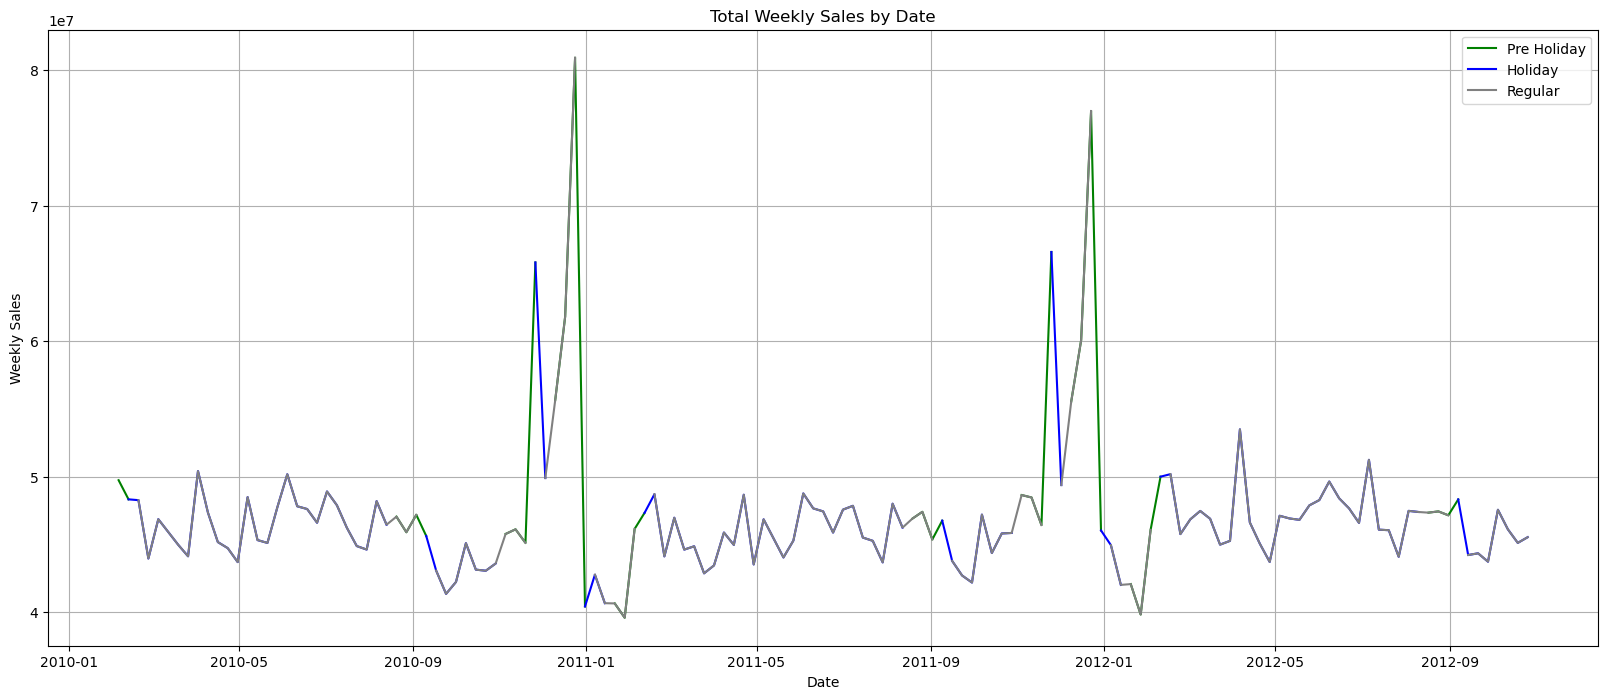

In [110]:
import matplotlib.dates as dates

fig, ax = plt.subplots(figsize=(20, 8))

pholiday = np.ma.masked_where(weeklysales['Holiday_Status'] == 'Pre-Holiday', weeklysales['Weekly_Sales'])
holiday = np.ma.masked_where(weeklysales['Holiday_Status'] == 'Holiday', weeklysales['Weekly_Sales'])
regular = np.ma.masked_where(weeklysales['Holiday_Status'] == 'Non-Holiday', weeklysales['Weekly_Sales'])

ax.plot(weeklysales['Date'], regular, color='Green', label='Pre Holiday')
ax.plot(weeklysales['Date'], pholiday, color='blue', label='Holiday')
ax.plot(weeklysales['Date'], holiday, color='grey', label='Regular')

ax.set_xlabel('Date')
ax.set_ylabel('Weekly Sales')
ax.set_title('Total Weekly Sales by Date')
ax.grid(True)
ax.legend()


plt.show()


<h2> Predictive Modeling

In [111]:
sales_cleaned = sales#.loc[sales['Date'].dt.year != 2012].loc[sales['Date'].dt.month != 5].loc[sales['Date'].dt.month != 6]  # TODO replace with mean of the same week in the previous year
features_cleaned = features#.loc[features['Date'].dt.year != 2012].loc[features['Date'].dt.month != 5].loc[features['Date'].dt.month != 6] # TODO replace  with mean of the same week in the previous year
features_cleaned['CPI'].fillna(features_cleaned['CPI'].mean(), inplace=True) # I filled the missing values with the mean

In [112]:
# lets join the features and sales data sets on the store and date columns
sales_features = pd.merge(sales_cleaned, features_cleaned, on=['Store', 'Date'], how='inner')
sales_features.info() # I checked to see if the merge was successful

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Store           421570 non-null  int64         
 1   Dept            421570 non-null  int64         
 2   Date            421570 non-null  datetime64[ns]
 3   Weekly_Sales    421570 non-null  float64       
 4   IsHoliday_x     421570 non-null  bool          
 5   pre_holiday     421570 non-null  bool          
 6   Holiday_Status  421570 non-null  object        
 7   Temperature     421570 non-null  float64       
 8   Fuel_Price      421570 non-null  float64       
 9   MarkDown1       150681 non-null  float64       
 10  MarkDown2       111248 non-null  float64       
 11  MarkDown3       137091 non-null  float64       
 12  MarkDown4       134967 non-null  float64       
 13  MarkDown5       151432 non-null  float64       
 14  CPI             421570 non-null  flo

In [113]:
sales_features.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,pre_holiday,Holiday_Status,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2,2010-02-05,50605.27,False,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
2,1,3,2010-02-05,13740.12,False,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
3,1,4,2010-02-05,39954.04,False,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
4,1,5,2010-02-05,32229.38,False,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False


In [114]:
#because we are going to do some predictions on the sales data, we need to encode the categorical data
sales_features['IsHoliday_x'] = sales_features['IsHoliday_x'].astype(int) # I converted the IsHoliday column to int
sales_features.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True) # I renamed the IsHoliday_x column to IsHoliday
sales_features.drop(columns=['IsHoliday_y'], inplace=True) # I dropped the IsHoliday_y column
sales_features.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,0,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,0,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-02-05,13740.12,0,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-02-05,39954.04,0,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,5,2010-02-05,32229.38,0,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


In [115]:
#markdown NaN can be replaced with 0 since markdown is a discount and 0 is no discount
sales_features['MarkDown1'].fillna(0, inplace=True)
for i in range(1,6):
    sales_features['MarkDown'+ str(i)].fillna(0, inplace=True)

sales_features.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,0,True,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
1,1,2,2010-02-05,50605.27,0,True,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
2,1,3,2010-02-05,13740.12,0,True,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
3,1,4,2010-02-05,39954.04,0,True,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
4,1,5,2010-02-05,32229.38,0,True,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106


In [116]:
holidays = sales_features[sales_features['IsHoliday'] == True]

In [117]:
holiday_dates = holidays['Date'].unique()
holiday_dates

array(['2010-02-12T00:00:00.000000000', '2010-09-10T00:00:00.000000000',
       '2010-11-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000',
       '2011-02-11T00:00:00.000000000', '2011-09-09T00:00:00.000000000',
       '2011-11-25T00:00:00.000000000', '2011-12-30T00:00:00.000000000',
       '2012-02-10T00:00:00.000000000', '2012-09-07T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [118]:
high_priority_dates = [] # from the kaggle descripion, the 4 weeks leading up to a holiday are deemed "high importance"
for date in holiday_dates:
    four_weeks_before_holiday = date - pd.DateOffset(weeks=4)
    high_priority_dates.append(np.datetime64(four_weeks_before_holiday))
print(high_priority_dates)
zipped = zip(holiday_dates, high_priority_dates)
timeDict = dict(zipped)


[numpy.datetime64('2010-01-15T00:00:00.000000'), numpy.datetime64('2010-08-13T00:00:00.000000'), numpy.datetime64('2010-10-29T00:00:00.000000'), numpy.datetime64('2010-12-03T00:00:00.000000'), numpy.datetime64('2011-01-14T00:00:00.000000'), numpy.datetime64('2011-08-12T00:00:00.000000'), numpy.datetime64('2011-10-28T00:00:00.000000'), numpy.datetime64('2011-12-02T00:00:00.000000'), numpy.datetime64('2012-01-13T00:00:00.000000'), numpy.datetime64('2012-08-10T00:00:00.000000')]


In [119]:
def is_pre_holiday(date): # defining  function to apply
    for key, value in timeDict.items():
        if date >= value and date <= key:
            return 1
    return 0


In [120]:
# adding the tag "is_pre_holiday"  if the date is 4 weeks before a holiday
sales_features['pre_holiday'] = sales_features['Date'].apply(is_pre_holiday)
sales_features.sample(5)


,Store,Dept,Date,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
248952,26,94,2010-08-27,38304.87,0,1,Pre-Holiday,57.23,2.770,0.00,0.00,0.00,0.00,0.00,132.693226,8.445
75739,8,79,2012-01-06,24035.38,0,0,Non-Holiday,43.47,3.157,3093.39,26001.46,96.35,500.91,4468.63,223.240967,5.825
11216,2,35,2010-05-07,5564.50,0,0,Non-Holiday,71.28,2.835,0.00,0.00,0.00,0.00,0.00,210.001102,8.200
70781,8,11,2010-08-27,18893.63,0,1,Pre-Holiday,74.92,2.619,0.00,0.00,0.00,0.00,0.00,214.936279,6.315
208815,22,59,2010-07-23,490.06,0,0,Non-Holiday,76.91,2.784,0.00,0.00,0.00,0.00,0.00,136.436692,8.433


In [121]:
#splitting the date into year, month, and day columns  # we will want keep the date depening on the model type. For this simple lin regress we do not want the date
sales_features['Year'] = sales_features['Date'].dt.year
sales_features['Month'] = sales_features['Date'].dt.month
sales_features['Day'] = sales_features['Date'].dt.day
sales_features.drop(columns=['Date'], inplace=True)
sales_features.sample(5)



,Store,Dept,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day
61081,7,28,106.38,0,1,Pre-Holiday,49.84,2.773,0.00,0.00,0.00,0.00,0.00,190.362161,9.017,2010,9,3
220891,23,26,12760.05,0,0,Non-Holiday,37.28,3.634,0.00,0.00,0.00,0.00,0.00,133.849226,5.114,2011,3,18
388242,41,54,14.24,0,1,Pre-Holiday,33.15,3.038,2464.60,2126.51,112.01,129.54,817.31,196.826279,6.589,2012,1,27
244915,25,3,6527.87,0,0,Non-Holiday,42.46,4.044,5432.06,4239.57,8.35,789.18,1044.74,214.312703,7.139,2012,4,13
417649,45,8,35596.86,0,0,Non-Holiday,63.75,3.711,0.00,0.00,0.00,0.00,0.00,187.029532,8.625,2011,9,23


In [122]:
# encoding the year into 1, 2, 3, 4
sales_features['Year'] = sales_features['Year'].map({2010: 1, 2011: 2, 2012: 3, 2013: 4})
sales_features.head()

,Store,Dept,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day
0,1,1,24924.50,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,2,5
1,1,2,50605.27,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,2,5
2,1,3,13740.12,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,2,5
3,1,4,39954.04,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,2,5
4,1,5,32229.38,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,2,5


In [88]:
sales_features['Month'].dtypes == 'int64' #confirming the type 

NameError: name 'sales_features' is not defined

In [ ]:
# Encoding the month and days cyclically thanks to http://blog.davidkaleko.com/feature-engineering-cyclical-features.html
# Basicly, we are ploting the month and day onto a "clock" and then using the angle of the clock hand to encode the month and day between -1 and 1 
sales_features['mnth_sin'] = np.sin((sales_features.Month-1)*(2.*np.pi/12))
sales_features['mnth_cos'] = np.cos((sales_features.Month-1)*(2.*np.pi/12))

In [ ]:
def day_sin(row): # for applying
    if row['Month'] == 1:
        return np.sin((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 2:
        return np.sin((row['Day']-1)*(2.*np.pi/28))
    elif row['Month'] == 3:
        return np.sin((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 4:
        return np.sin((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 5:
        return np.sin((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 6:
        return np.sin((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 7:
        return np.sin((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 8:
        return np.sin((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 9:
        return np.sin((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 10:
        return np.sin((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 11:
        return np.sin((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 12:
        return np.sin((row['Day']-1)*(2.*np.pi/31))
    else:
        return np.nan

In [ ]:
def day_cos(row):   
    if row['Month'] == 1:
        return np.cos((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 2:
        return np.cos((row['Day']-1)*(2.*np.pi/28)) 
    elif row['Month'] == 3:
        return np.cos((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 4:
        return np.cos((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 5:
        return np.cos((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 6:
        return np.cos((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 7:
        return np.cos((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 8:
        return np.cos((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 9:
        return np.cos((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 10:
        return np.cos((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 11:
        return np.cos((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 12:
        return np.cos((row['Day']-1)*(2.*np.pi/31))
    else:
        return np.nan

In [ ]:
sales_features['day_sin'] = sales_features.apply(day_sin, axis=1)
sales_features['day_cos'] = sales_features.apply(day_cos, axis=1) 

In [ ]:
sales_features.drop(columns=['Year', 'Month', 'Day'], inplace=True) # replaced with the encoded values
sales_features.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,mnth_sin,mnth_cos,day_sin,day_cos
0,1,1,2010-02-05,24924.50,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0.5,0.866025,0.781831,0.62349
1,1,2,2010-02-05,50605.27,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0.5,0.866025,0.781831,0.62349
2,1,3,2010-02-05,13740.12,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0.5,0.866025,0.781831,0.62349
3,1,4,2010-02-05,39954.04,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0.5,0.866025,0.781831,0.62349
4,1,5,2010-02-05,32229.38,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0.5,0.866025,0.781831,0.62349


In [ ]:
sales_features.drop(columns=['Holiday_Status'], inplace=True) #replaced with IsHoliday and Pre_holiday
sales_features.sample(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,pre_holiday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,mnth_sin,mnth_cos,day_sin,day_cos
61931,7,85,2010-11-26,1455.58,1,1,17.95,2.742,0.0,0.0,0.0,0.0,0.0,191.012180,9.137,-0.866025,0.500000,-8.660254e-01,0.500000
35598,4,79,2011-09-16,52290.27,0,0,72.76,3.532,0.0,0.0,0.0,0.0,0.0,129.430600,5.644,-0.866025,-0.500000,1.224647e-16,-1.000000
120040,13,3,2010-09-24,18019.06,0,0,68.22,2.872,0.0,0.0,0.0,0.0,0.0,126.190033,7.951,-0.866025,-0.500000,-9.945219e-01,0.104528
269917,28,52,2010-11-19,2962.81,0,1,58.18,3.161,0.0,0.0,0.0,0.0,0.0,126.607200,14.313,-0.866025,0.500000,-5.877853e-01,-0.809017
258071,27,42,2010-06-11,10933.65,0,0,68.90,2.972,0.0,0.0,0.0,0.0,0.0,136.287426,8.058,0.500000,-0.866025,8.660254e-01,-0.500000


In [ ]:
#one hot encoding the store, department numbers
sales_features = pd.get_dummies(sales_features, columns=['Store', 'Dept']) 
sales_features.head()

,Date,Weekly_Sales,IsHoliday,pre_holiday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99
0,2010-02-05,24924.50,0,1,42.31,2.572,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2010-02-05,50605.27,0,1,42.31,2.572,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2010-02-05,13740.12,0,1,42.31,2.572,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2010-02-05,39954.04,0,1,42.31,2.572,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,2010-02-05,32229.38,0,1,42.31,2.572,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y = sales_features['Weekly_Sales']
X = sales_features.drop(columns=['Weekly_Sales', 'Date'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the accuracy of the prediction using R-squared score
accuracy = model.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(accuracy, mse)


ValueError: could not convert string to float: 'Pre-Holiday'

In [ ]:
# Create a dataframe of the model coefficients  (How important each feature is)
coef = pd.DataFrame(list(zip(X.columns, model.coef_)), columns=['Features', 'Coefficients']).sort_values(by='Coefficients', ascending=False)
coef

,Features,Coefficients
1,Dept,4062.071883
6,MarkDown1,851.457516
10,MarkDown5,838.110104
8,MarkDown3,800.717810
3,pre_holiday,362.457657
4,Temperature,249.893477
7,MarkDown2,211.516124
9,MarkDown4,-71.364312
2,IsHoliday,-78.606942
12,Unemployment,-140.874265


<h3> Our scores arent too good, lets try breaking it down by store

In [ ]:
summary_rows = []
for store in features['Store'].unique():
    y = sales_features['Weekly_Sales'].loc[sales_features[f'Store_{store}'] == 1]
    X = sales_features.drop(columns=['Weekly_Sales', 'Date']).loc[sales_features[f'Store_{store}'] == 1]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Create a linear regression model
    model = LinearRegression()

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Evaluate the accuracy of the prediction using R-squared score
    accuracy = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)

    row = store, accuracy, mse
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows, columns=['Store', 'R-squared score', 'Mean Squared Error'])
summary_df.describe()


In [ ]:
summary_df.sort_values('R-squared score').head(10)

,Store,R-squared score,Mean Squared Error
24,25,-8.719337e+24,1.287699e+33
20,21,-7.084311e+24,1.256292e+33
35,36,-5.064099e+24,8.820457e+32
16,17,-3.423312e+24,8.708652e+32
22,23,-1.500764e+24,6.163312e+32
37,38,-8.997406e+22,1.834252e+31
14,15,6.863112e-01,4.686564e+07
21,22,7.336026e-01,1.049084e+08
11,12,7.959261e-01,7.008600e+07
34,35,8.003071e-01,5.296227e+07


KeyError: 'Store_1'

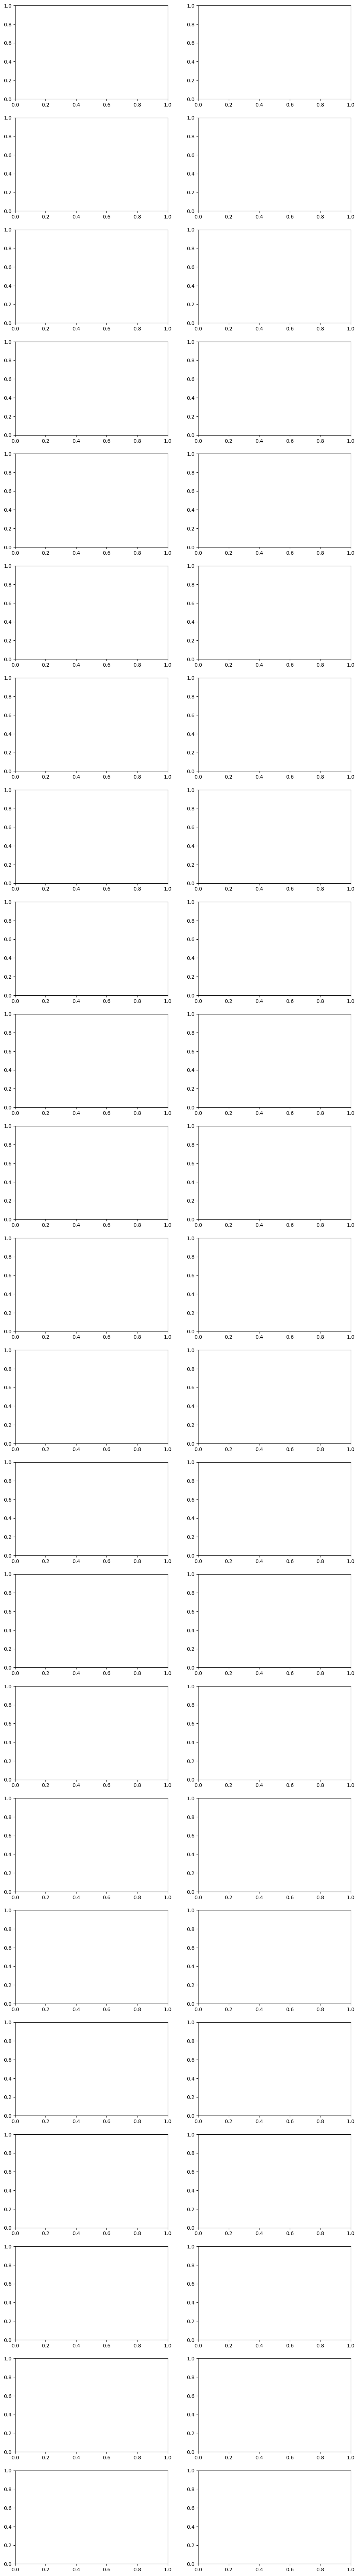

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set the number of subplots and their arrangement
num_plots = len(summary_df)
num_cols = 2  # Two subplots per row
num_rows = (num_plots + 1) // num_cols

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows))

# Flatten the axes array if it has more than one row
axes = axes.flatten()

# Iterate over each store and plot the predicted and actual values
for i, store in enumerate(features['Store'].unique()):
    ax = axes[i]  # Select the current subplot

    # Filter the data for the current store
    store_data = sales_features.loc[sales_features[f'Store_{store}'] == 1]
    X = store_data.drop(columns=['Weekly_Sales', 'Date'])
    y = store_data['Weekly_Sales']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Create a linear regression model
    model = LinearRegression()

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the entire data
    y_pred = model.predict(X_scaled)

    # Get the corresponding dates for the entire store data
    all_dates = store_data['Date']

    # Plot the predicted and actual values as lines
    ax.plot(all_dates, y_pred, '-', label='Predicted')
    ax.plot(all_dates, y, '-', label='Actual')
    score = model.score(X_test, y_test)
    # Set plot title and labels
    ax.set_title(f'Store {store} - Accuracy: {round(score, 2)}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales')

    # Set x-axis ticks to display monthly data points
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    # Rotate x-axis ticks
    ax.tick_params(axis='x', rotation=45)

    # Set x-axis limits
    x_min = min(all_dates)
    x_max = max(all_dates)
    ax.set_xlim(x_min, x_max)
    ax.legend()

# Adjust the layout and spacing of subplots
fig.tight_layout()

# Show the plot
plt.show()


,Features,Coefficients
0,IsHoliday,3.994140e+00
1,pre_holiday,4.402896e+02
2,Temperature,-1.690854e+01
3,Fuel_Price,-2.177066e+02
4,MarkDown1,3.118125e+01
...,...,...
136,Dept_95,1.993443e+13
137,Dept_96,1.734622e+13
138,Dept_97,1.969348e+13
139,Dept_98,1.899767e+13


In [ ]:
#create a dataframe of the model feature importances
importances = pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_))), columns=['Features', 'Importance'])
importances.sort_values(by=['Importance'], ascending=False, inplace=True)
importances.head(10)

,Features,Importance
9,CPI,10494.759031
6,MarkDown3,564.833075
1,pre_holiday,451.277127
3,Fuel_Price,314.074974
12,mnth_sin,299.315415
13,mnth_cos,234.215010
4,MarkDown1,203.670936
8,MarkDown5,161.731121
14,day_sin,66.744257
2,Temperature,53.471910


In [ ]:
sales_features

,Weekly_Sales,IsHoliday,pre_holiday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99
0,24924.50,0,1,42.31,2.572,0.00,0.00,0.0,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
1,50605.27,0,1,42.31,2.572,0.00,0.00,0.0,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
2,13740.12,0,1,42.31,2.572,0.00,0.00,0.0,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
3,39954.04,0,1,42.31,2.572,0.00,0.00,0.0,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
4,32229.38,0,1,42.31,2.572,0.00,0.00,0.0,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,2487.80,0,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,...,0,0,0,1,0,0,0,0,0,0
421566,5203.31,0,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,...,0,0,0,0,1,0,0,0,0,0
421567,56017.47,0,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,...,0,0,0,0,0,1,0,0,0,0
421568,6817.48,0,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,...,0,0,0,0,0,0,0,1,0,0


Low R-Squared Score, we are looking for at least a .7, more like .9 so lets try other stuff

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Create a Gradient Boosting Regression model
model = GradientBoostingRegressor()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the accuracy of the prediction using R-squared score
accuracy = r2_score(y_test, y_pred)
print("Gradient Boosting R-squared score:", accuracy)


Gradient Boosting R-squared score: 0.4382107782995288


In [ ]:
from sklearn.svm import SVR

# Create a Support Vector Regression model
model = SVR()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the accuracy of the prediction using R-squared score
accuracy = r2_score(y_test, y_pred)
print("Support Vector Regression R-squared score:", accuracy)


In [ ]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import r2_score

# Assuming sales_data is a DataFrame containing the time series data

# Extract the target variable as a Series
sales_data = sales_features['Weekly_Sales']

# Split the data into training and testing sets
train_data_length = int(0.8 * len(sales_data))
train_data = sales_data[:train_data_length]
test_data = sales_data[train_data_length:]

# Create and fit the Triple Exponential Smoothing model
model = ExponentialSmoothing(train_data, trend="add", seasonal="add", seasonal_periods=12)
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

# Evaluate the model
accuracy = r2_score(test_data, predictions)
print("Triple Exponential Smoothing R-squared score:", accuracy[:4])


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\xanen\anaconda3\envs\retail\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\xanen\AppData\Local\Temp\ipykernel_1492\892792965.py", line 17, in <module>
    model_fit = model.fit()
                ^^^^^^^^^^^
  File "c:\Users\xanen\anaconda3\envs\retail\Lib\site-packages\pandas\util\_decorators.py", line 211, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\xanen\anaconda3\envs\retail\Lib\site-packages\pandas\util\_decorators.py", line 211, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\xanen\anaconda3\envs\retail\Lib\site-packages\pandas\util\_decorators.py", line 211, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\xanen\anaconda3\envs\retail\Lib\site-packages\statsmodels\tsa\holtwinters\model.py", li